# AVALIAÇÃO DE RISCO DE CRÉDITO

O negócio bancário tem como principal know-how a capacidade de gerenciamento de risco financeiro. O cálculo da taxa de inadimplência de um carteira de crédito desempenha papel fundamental no desempenho e planejamento de uma instituição financeira.

O objetivo destes cálculos é identificar a probabilidade de um cliente entrar em default que é o não cumprimento de uma obrigação ou condição de um empréstimo, sendo que normalmente sua causa é a incapacidade financeira do cliente.

Instituições pelo mundo têm incorporado o uso de modelos de machine learning para o aprimoramento de sua avaliação de risco. Neste contexto, temos uma base de dados da fintech Nubank que será utilizada para modelagem afim de predizer a probabilidade de default para seus clientes.

# IMPORTANDO DADOS E BIBLIOTECAS

In [ ]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# importar algoritmos e metricas
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from scipy.stats import ks_2samp
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
db = pd.read_csv("http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0")

# ANALISANDO OS DADOS

## Prévia dos dados

In [ ]:
db.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,...,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,...,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,...,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


In [ ]:
print(80*'*')
print(f'Dimensões: {db.shape[0]} linhas e {db.shape[1]} colunas.\n')
print(80*'*')
print(f'Colunas: {db.columns.values}\n')
print(80*'*')
print('Tipos:', '\n\n'+str(db.dtypes)+'\n')
print(80*'*')
print('Quantidade de valores únicos: ', '\n\n'+str(db.nunique()))
print('\n'+80*'*')
print('Prévia dos valores: \n')
for col in db.columns.values:
  if len(db[col].unique()) > 5:
    print('\n'+col+': ', db[col].unique()[:5], 'entre outros...')
  else:
    print('\n'+col+': ', db[col].unique())
print('\n'+80*'*')
print('Estatística Descritiva: \n\n', db.describe().to_string(max_cols=db.shape[1]))
print('\n'+80*'*')
print('Valores Nulos:', '\n\n'+str((db.isnull().sum()/db.shape[0]).sort_values(ascending=False))+'\n\n')
print('\n'+80*'*')
num_but_cat = [col for col in db.columns if db[col].nunique() < 10 and db[col].dtypes != "O"]
cat_but_car = [col for col in db.columns if db[col].nunique() > 20 and db[col].dtypes == "O"]
print('Variáveis numéricas que podem ser categoricas: ', num_but_cat)
print('Variáveis categóricas com cardinalidade: ', cat_but_car)

********************************************************************************
Dimensões: 45000 linhas e 43 colunas.

********************************************************************************
Colunas: ['ids' 'target_default' 'score_1' 'score_2' 'score_3' 'score_4' 'score_5'
 'score_6' 'risk_rate' 'last_amount_borrowed' 'last_borrowed_in_months'
 'credit_limit' 'reason' 'income' 'facebook_profile' 'state' 'zip'
 'channel' 'job_name' 'real_state' 'ok_since' 'n_bankruptcies'
 'n_defaulted_loans' 'n_accounts' 'n_issues' 'application_time_applied'
 'application_time_in_funnel' 'email'
 'external_data_provider_credit_checks_last_2_year'
 'external_data_provider_credit_checks_last_month'
 'external_data_provider_credit_checks_last_year'
 'external_data_provider_email_seen_before'
 'external_data_provider_first_name' 'external_data_provider_fraud_score'
 'lat_lon' 'marketing_channel' 'profile_phone_number' 'reported_income'
 'shipping_state' 'shipping_zip_code' 'profile_tags' 'user_ag

## Sumário

O dataset possui 45000 linhas e 43 colunas.

A variável target para risco de default está armazenada na coluna `target_default`.

A base de dados possui colunas codificadas são elas: <br>
* `['ids', 'score_1', 'score_2','reason', 'state', 'zip', 'channel', 'job_name', 'real_state']`

Features relacionadas a cadastro de clientes:
<br>
* `['facebook_profile', 'email', 'shipping_state', 'shipping_zip_code','profile_phone_number','profile_tags', 'income', 'reported_income', 'marketing_channel']`

Features relacionadas a análise de crédito:
* `['score_3','score_4', 'score_5', 'score_6', 'risk_rate', 'last_amount_borrowed', 'last_borrowed_in_months', 'credit_limit', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues']`

Features derivadas de bureaus de crédito:
* `['external_data_provider_credit_checks_last_2_year', 'external_data_provider_credit_checks_last_month', 'external_data_provider_credit_checks_last_year', 'external_data_provider_fraud_score']`

Alguns dados de telemetria: <br>
* `['user_agent','application_time_applied', 'application_time_in_funnel']`

As variáveis abaixo demandam aprofundamento em sua sistemática para compreensão da informação:

* `['ok_since','external_data_provider_email_seen_before','external_data_provider_first_name',  'lat_lon']`


# SELEÇÃO DE FEATURES

Considerando a informação contida e sua utilidade removeremos as seguintes colunas:



*   Variáveis cadastrais/contato de clientes: <br>
`['ids', 'profile_phone_number', 'email', 'marketing_channel']`

*   Valores codificados: <br>
`['ids', 'score_1', 'score_2','reason', 'state', 'zip', 'channel', 'job_name', 'real_state']`

*   Telemetria: <br>
`['user_agent','application_time_applied', 'application_time_in_funnel']`

*   Demandam maior aprofundamento: <br>
`['ok_since','external_data_provider_email_seen_before','external_data_provider_credit_checks_last_2_year', 'external_data_provider_first_name',  'lat_lon', 'shipping_state', 'shipping_zip_code']`

* Scores sem informação sobre origem ou método de cálculo: <br>
`['risk_rate', 'score_3', 'score_4', 'score_5', 'score_6', 'external_data_provider_fraud_score']`

* Variável target para detecção de fraude: <br>
`['target_fraud]`



Teremos então as seguintes features para o treinamento do modelo:

* `last_amount_borrowed`: Último valor emprestado.

* `last_borrowed_in_months`: Quantos meses do último empréstimo.

* `credit_limit`: Limite de crédito.

* `income`: Renda.

* `reported_income`: Renda informada pelo cliente.

* `facebook_profile`: Perfil do facebook conhecido/informado.

* `n_bankruptcies`: quantidade de falências/defaults.

* `n_defaulted_loans`: Quantidade de empréstimos com default.

* `n_accounts`: Número de contas.

* `n_issues`: Número de solicitações de crédito.

* `external_data_provider_credit_checks_last_month`: Quantidade de checagens no bureau de crédito no último mês.

* `external_data_provider_credit_checks_last_year`: Quantidade de checagens no bureau de crédito no último ano.



In [ ]:
df = db.drop(['ids', 'profile_phone_number', 'email', 'marketing_channel', 'score_1', 'score_2', 'risk_rate', 'score_3', 'score_4', 'score_5', 'score_6','reason', 'state', 'zip', 'channel', 'job_name', 'real_state',
          'user_agent','application_time_applied', 'application_time_in_funnel', 'ok_since','external_data_provider_email_seen_before',
          'external_data_provider_credit_checks_last_2_year', 'external_data_provider_first_name', 'external_data_provider_fraud_score', 'lat_lon', 'profile_tags','shipping_state', 'shipping_zip_code', 'target_fraud'], axis=1).copy()
print(df.head().to_string(max_cols=df.shape[1]))

  target_default  last_amount_borrowed  last_borrowed_in_months  credit_limit     income facebook_profile  n_bankruptcies  n_defaulted_loans  n_accounts  n_issues  external_data_provider_credit_checks_last_month  external_data_provider_credit_checks_last_year  reported_income
0          False              25033.92                     36.0           0.0   65014.12             True             0.0                0.0        18.0      18.0                                                2                                             0.0          57849.0
1          False                   NaN                      NaN       39726.0  100018.91            False             0.0                0.0        14.0      14.0                                                1                                             0.0           4902.0
2           True               7207.92                     36.0           NaN   65023.65              NaN             0.0                0.0        10.0       NaN       

# MISSING/NULOS


Analisando o resumo da estatística descritiva somos capazes de destacar algumas observações:

* `['reported_income']` possui valores infinitos, que não fazem sentido no contexto de renda.

* `['last_amount_borrowed','last_borrowed_in_months']` possui > 50% de valores ausentes.

* `['external_data_provider_credit_checks_last_year', 'credit_limit', 'n_issues']` possui >25% de valores ausentes.

* `['facebook_profile]` terá valores NA substituídos por False (não possui).

* Excluiremos registros que possuem valores nulos para `['n_bankruptcies', 'n_defaulted_loans','reported_income']`

In [ ]:
#Removeremos valores inválidos para varíavel target.
rows = df.shape[0]
df.dropna(subset=['target_default'], inplace=True)
print(f'target_default: {rows - df.shape[0]} linhas excluídas.')
rows=df.shape[0]

df['reported_income'] = df['reported_income'].replace(np.inf, np.nan)
df.dropna(subset=['reported_income'], inplace=True)
print(f'reported_income: {rows - df.shape[0]} linhas excluídas.')
rows=df.shape[0]

df.dropna(subset=['n_bankruptcies'], inplace=True)
print(f'n_bankruptcies: {rows - df.shape[0]} linhas excluídas.')
rows=df.shape[0]

df.dropna(subset=['n_defaulted_loans'], inplace=True)
print(f'n_defaulted_loans: {rows - df.shape[0]} linhas excluídas.')
rows=df.shape[0]

df['last_amount_borrowed'].fillna(value=0, inplace=True)
df['last_borrowed_in_months'].fillna(value=0, inplace=True)

df['external_data_provider_credit_checks_last_year'].fillna(value=0, inplace=True)
df['credit_limit'].fillna(value=0, inplace=True)
df['n_issues'].fillna(value=0, inplace=True)

#df['facebook_profile'].fillna(value=False, inplace=True)

df = df.copy().reset_index(drop=True)

target_default: 3259 linhas excluídas.
reported_income: 66 linhas excluídas.
n_bankruptcies: 135 linhas excluídas.
n_defaulted_loans: 0 linhas excluídas.


# FEATURES x TARGET

In [ ]:
df['target_default'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

False    84.0%
True     16.0%
Name: target_default, dtype: object

In [ ]:
df['target_default'].value_counts()

False    34909
True      6631
Name: target_default, dtype: int64

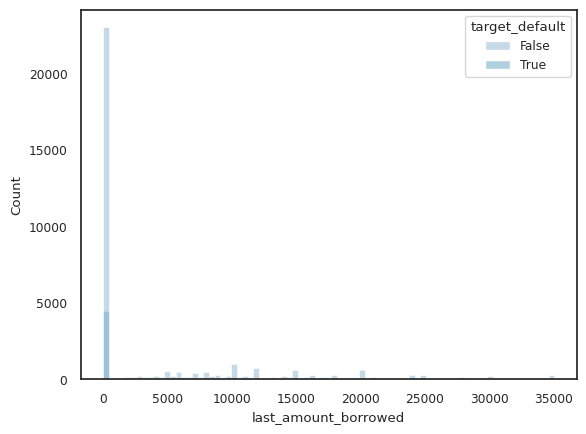

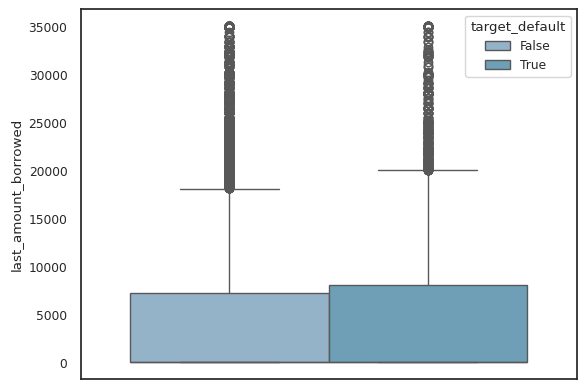

In [ ]:
sns.histplot(data=df, x='last_amount_borrowed', hue='target_default')
plt.show()
sns.boxplot(data=df, y='last_amount_borrowed', hue='target_default')
plt.show()

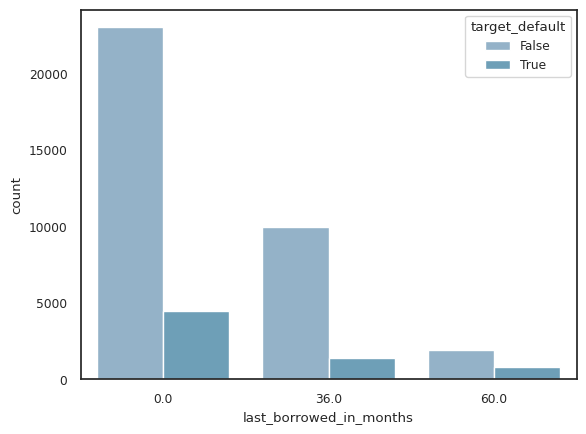

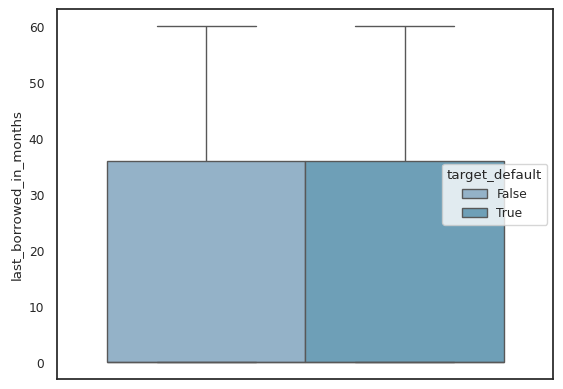

In [ ]:
sns.countplot(data=df, x='last_borrowed_in_months', hue='target_default')
plt.show()
sns.boxplot(data=df, y='last_borrowed_in_months', hue='target_default')
plt.show()

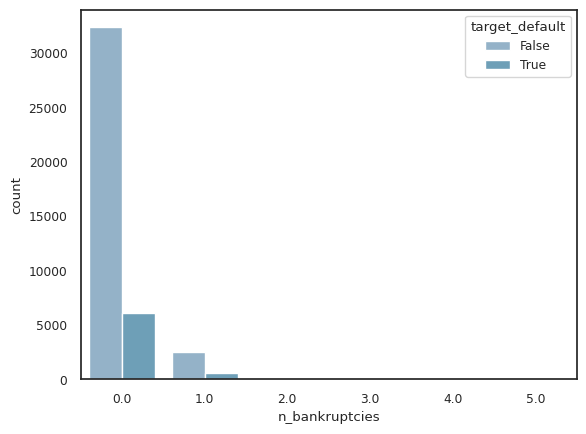

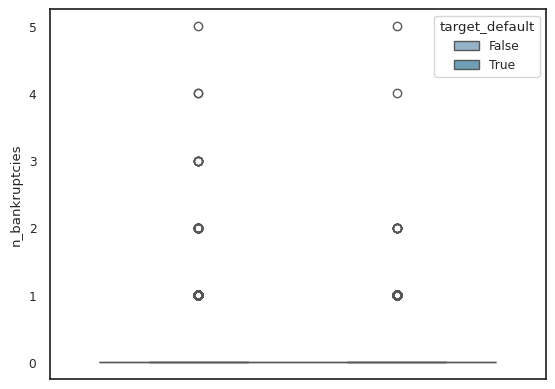

In [ ]:
sns.countplot(data=df, x='n_bankruptcies', hue='target_default')
plt.show()
sns.boxplot(data=df, y='n_bankruptcies', hue='target_default')
plt.show()

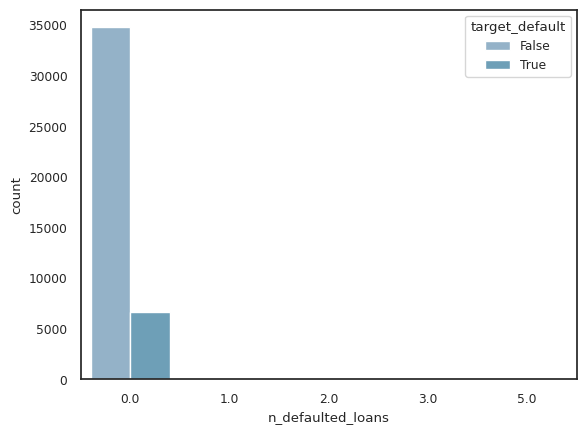

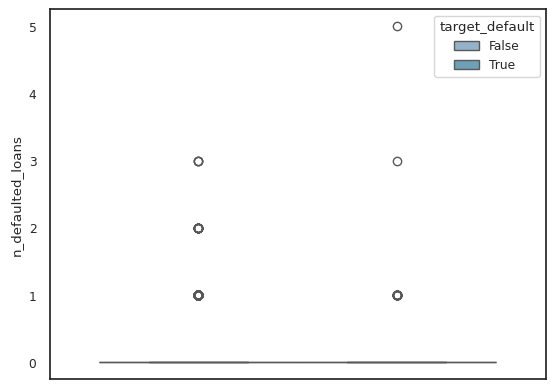

In [ ]:
sns.countplot(data=df, x='n_defaulted_loans', hue='target_default')
plt.show()
sns.boxplot(data=df, y='n_defaulted_loans', hue='target_default')
plt.show()

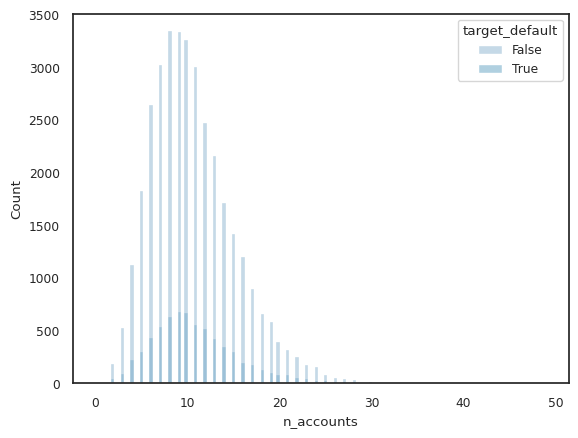

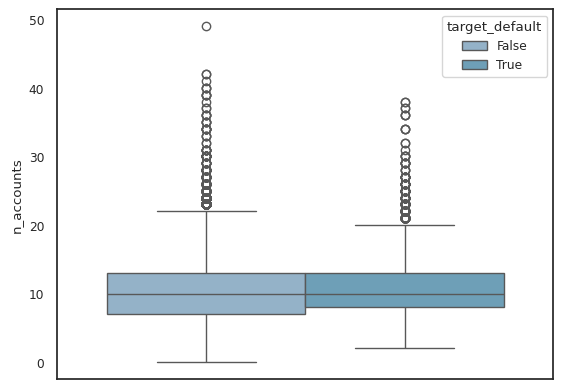

In [ ]:
sns.histplot(data=df, x='n_accounts', hue='target_default')
plt.show()
sns.boxplot(data=df, y='n_accounts', hue='target_default')
plt.show()

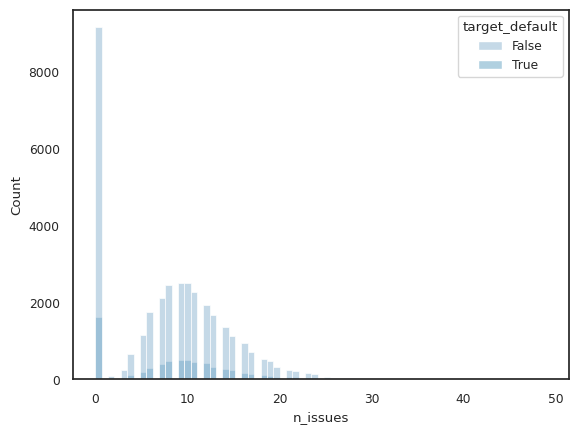

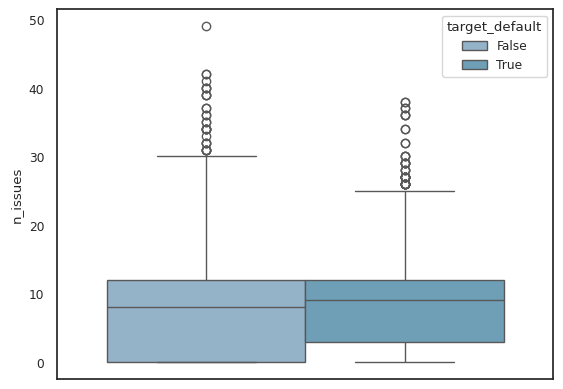

In [ ]:
sns.histplot(data=df, x='n_issues', hue='target_default')
plt.show()
sns.boxplot(data=df, y='n_issues', hue='target_default')
plt.show()

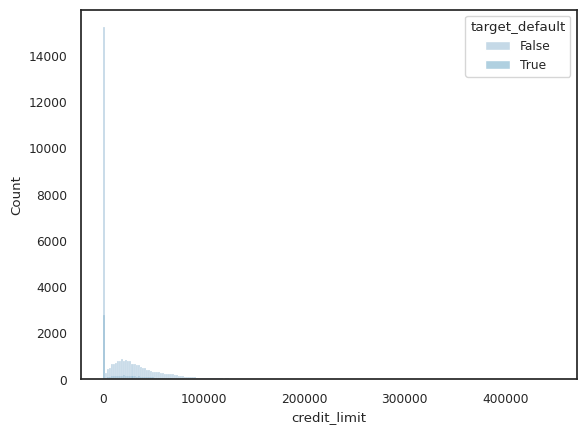

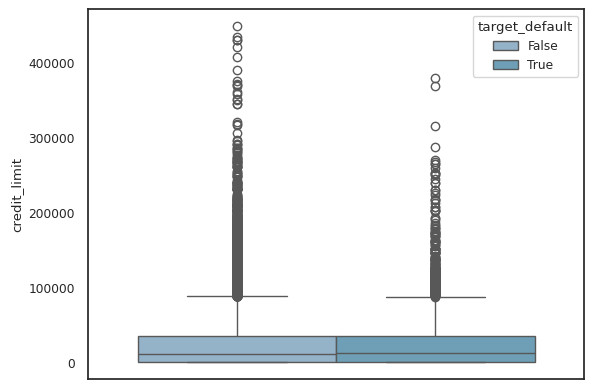

In [ ]:
sns.histplot(data=df, x='credit_limit', hue='target_default')
plt.show()
sns.boxplot(data=df, y='credit_limit', hue='target_default')
plt.show()

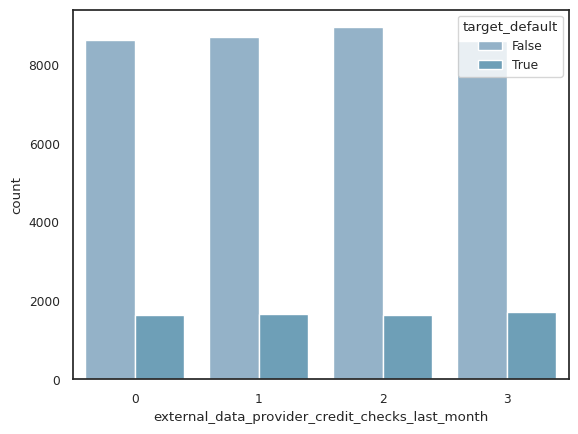

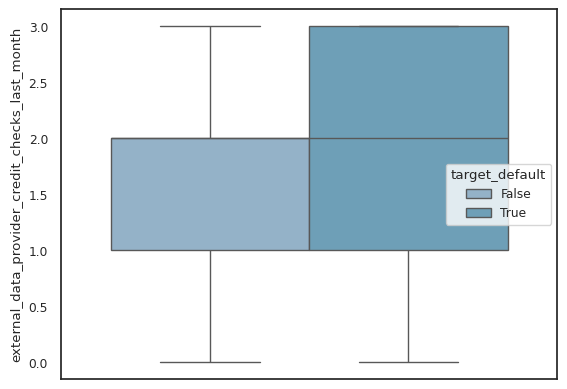

In [ ]:
sns.countplot(data=df, x='external_data_provider_credit_checks_last_month', hue='target_default')
plt.show()
sns.boxplot(data=df, y='external_data_provider_credit_checks_last_month', hue='target_default')
plt.show()

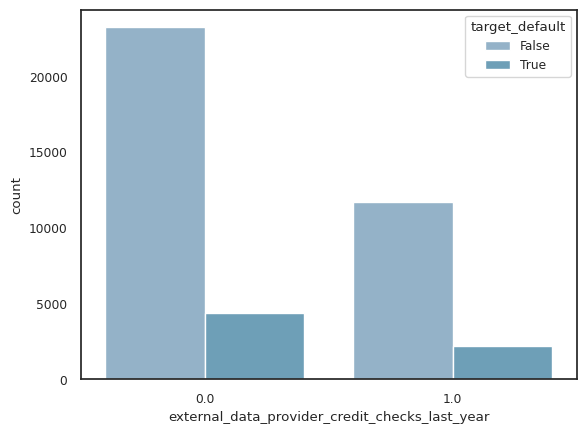

In [ ]:
sns.countplot(data=df, x='external_data_provider_credit_checks_last_year', hue='target_default')
plt.show()

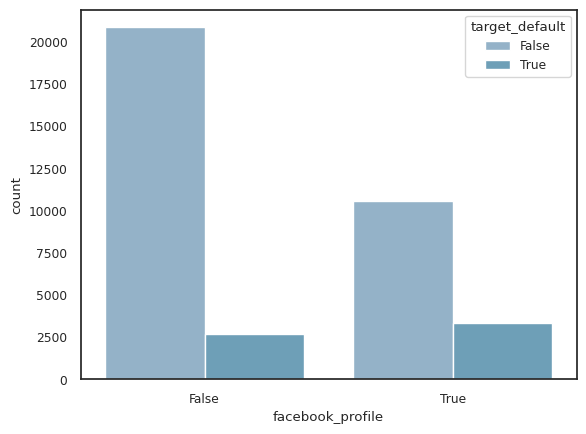

In [ ]:
sns.countplot(data=df, x='facebook_profile', hue='target_default')
plt.show()

## Outliers

Avaliando `income (renda)` e `reported income (Renda informada)` constatamos a existência de outliers. Realizaremos a regularização destes dados retirando os registros com renda informada acima de R$ 1.000.000.

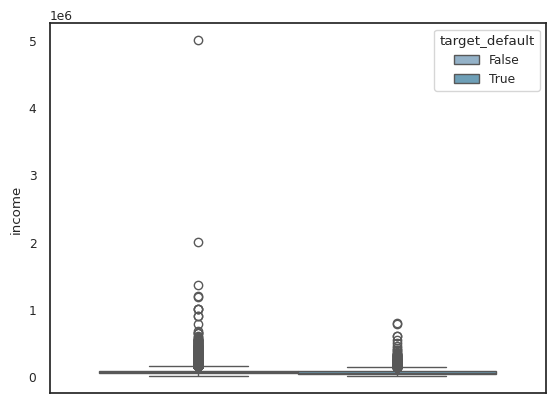


Renda acima de 1.000.000: 8


In [ ]:
sns.boxplot(data=df, y='income', hue='target_default')
plt.show()

c = df[df['income'] >= 1e6]['income'].count()
print(f'\nRenda acima de 1.000.000: {c}')

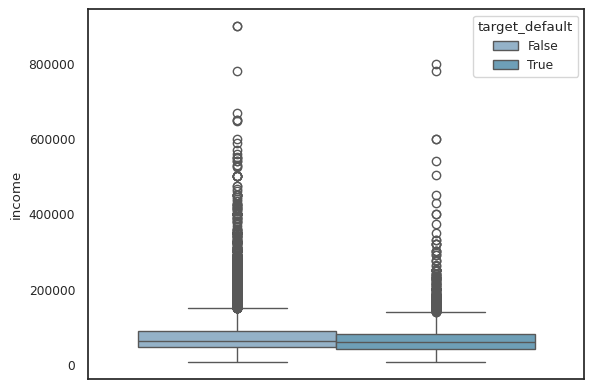

In [ ]:
#Removendo Renda acima de 1.000.000
df = df[df['income'] <= 1e6].copy()
sns.boxplot(data=df, y='income', hue='target_default')
plt.show()

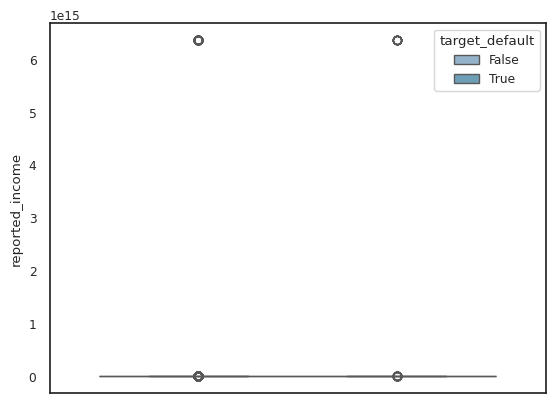


Renda informada acima de 1.000.000: 314


In [ ]:
sns.boxplot(data=df, y='reported_income', hue='target_default')
plt.show()

c = df[df['reported_income'] >= 1e6]['income'].count()
print(f'\nRenda informada acima de 1.000.000: {c}')

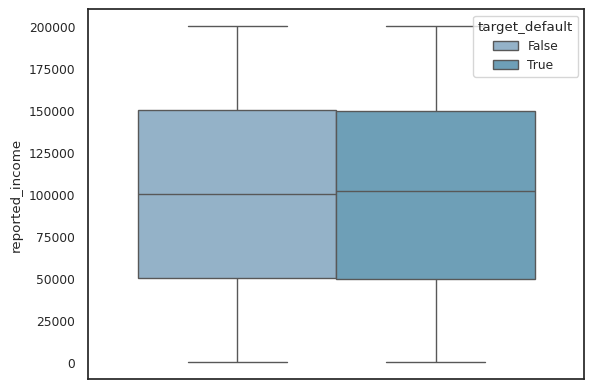

In [ ]:
df = df[df['reported_income'] <= 1e6].copy()
sns.boxplot(data=df, y='reported_income', hue='target_default')
plt.show()

# PADRONIZANDO OS DADOS

In [ ]:
lbl_y = 'target_default'

def data_prep(df, lbl_y):
  scaled_df = df.copy()

  # normalizar as colunas numéricas
  num_cols = scaled_df.drop(lbl_y, axis=1).select_dtypes(exclude='object').columns
  scaled_df[num_cols] = MinMaxScaler().fit_transform(scaled_df[num_cols].values)
  encoded_df = scaled_df.copy()

  # extrair as colunas categóricas
  cat_cols = encoded_df.select_dtypes('object').columns

  # codificar cada coluna categórica
  for col in cat_cols:
    encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

  return encoded_df

In [ ]:
# normalizando numéricas e codificando categóricas.
encoded_df = data_prep(df, lbl_y)

# IV e VIF

In [ ]:
def show_VIF(df, feature_cols):
  # the independent variables set
  X = df[feature_cols].copy()
  X['intercept'] = 1

  # VIF dataframe
  vif_data = pd.DataFrame()
  vif_data["feature"] = X.columns

  # calculating VIF for each feature
  vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

  vif_data = vif_data.sort_values(by='VIF', ascending=False)

  print("\n", vif_data)

In [ ]:
feature_cols = list(df.drop(['target_default'], axis=1).columns)

In [ ]:
show_VIF(encoded_df,feature_cols)


                                             feature        VIF
12                                        intercept  14.417828
0                              last_amount_borrowed   3.601614
1                           last_borrowed_in_months   3.519360
8                                          n_issues   2.203633
7                                        n_accounts   1.839787
2                                      credit_limit   1.457976
3                                            income   1.176576
5                                    n_bankruptcies   1.008631
6                                 n_defaulted_loans   1.001629
10   external_data_provider_credit_checks_last_year   1.000557
11                                  reported_income   1.000340
4                                  facebook_profile   1.000231
9   external_data_provider_credit_checks_last_month   1.000082


Considerando VIF > 5 para sinais de multicolinearidade não encontramos pontos de atenção.

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [round(d['IV'].sum(), 4)]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

    newDF['Level'] = 'Very Weak'
    newDF.loc[(newDF['IV'] > 0.02) & (newDF['IV'] < 0.1), 'Level'] = 'Weak'
    newDF.loc[(newDF['IV'] > 0.1) & (newDF['IV'] < 0.3), 'Level'] = 'Average'
    newDF.loc[(newDF['IV'] > 0.3) & (newDF['IV'] < 0.5), 'Level'] = 'Strong'
    newDF.loc[(newDF['IV'] > 0.5), 'Level'] = 'Suspicious'

    newDF = newDF.sort_values(by='IV', ascending=False)
    #Show WOE Table
    if show_woe == True:
        print("\n", newDF)

    return newDF, woeDF

In [ ]:
newDF, woeDF = iv_woe(encoded_df, lbl_y, bins=100, show_woe=True)


                                           Variable      IV      Level
0                                 facebook_profile  0.1749    Average
0                          last_borrowed_in_months  0.0712       Weak
0                                           income  0.0456       Weak
0                                  reported_income  0.0223       Weak
0                             last_amount_borrowed  0.0168  Very Weak
0                                     credit_limit  0.0116  Very Weak
0                                         n_issues  0.0084  Very Weak
0                                       n_accounts  0.0081  Very Weak
0                                   n_bankruptcies  0.0016  Very Weak
0                                n_defaulted_loans  0.0011  Very Weak
0  external_data_provider_credit_checks_last_month  0.0007  Very Weak
0   external_data_provider_credit_checks_last_year  0.0000  Very Weak


Para features relacionadas a risco de crédito mais óbvias temos IV Fraco ou Muito Fraco. Temos IV médio para facebook_profile, seria interessante verificar com a àrea de negócio a sistemática de cadastro desta informação e um estudo mais aprofundado da mesma.

# MATRIZ DE CORRELAÇÃO

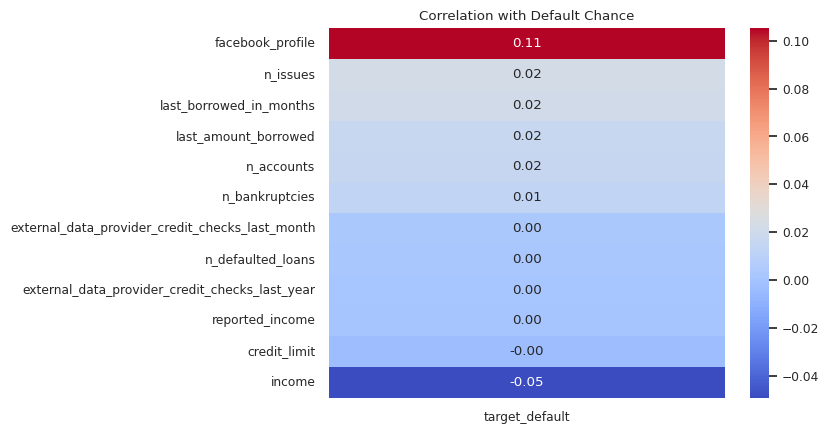

In [ ]:
corr = encoded_df.corr()
target_corr = corr['target_default'].drop('target_default')

target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Default Chance')
plt.show()

As correlações levantadas são bastante fracas porém em linha com o presumido para risco de crédito exceto para `facebook_profile`.

Aumentam o risco de default:

* `Número de solicitações de crédito` (n_issues), `endividamento` (last_borrowed_months e last_amount_borrowed) e `número de falências` (n_bankruptcies).

Reduzem o risco de default:

* `Limite de crédito` (credit_limit) e `income` (income) representando a confiança na capacidade de pagamento.


# SPLIT PARA TREINO E TESTE

In [ ]:
# separar as variáveis independentes da variável alvo
X = encoded_df.drop(lbl_y, axis=1)
y = encoded_df[lbl_y]

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TREINAMENTO DOS MODELOS

Agruparemos o código para treinamento e cálculo das métricas em uma função.

In [ ]:
def encontra_melhor_modelo(X_train, X_test, y_train, y_test, metrica='balanced_accuracy'):

  # Definindo os modelos
  modelos = [
      ('Logistic Regression', LogisticRegression(max_iter=1000)),
      ('Random Forest', RandomForestClassifier()),
      ('Gradient Boosting', GradientBoostingClassifier()),
      ('XGBoosting', XGBClassifier(learning_rate=0.1, max_depth=10))
  ]

  # Treinamento dos modelos, avaliação e seleção.
  melhor_modelo = None
  melhor_score = -np.inf

  print("Performance dos Modelos:")
  for nome, modelo in modelos:
      modelo.fit(X_train, y_train)

      y_pred = modelo.predict(X_test)

      #sorting model for desired metric
      if metrica == 'accuracy':
        accuracy = metrics.accuracy_score(y_test, y_pred)
        metrica_valor = metrica_valor
        print(f"{nome} - Acurácia: {metrica_valor:.5f}")

      elif metrica == 'balanced_accuracy':
        balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
        metrica_valor = balanced_accuracy
        print(f"{nome} - Acurácia Balanceada: {metrica_valor:.5f}")

      elif metrica == 'f1':
        f1 = metrics.f1_score(y_test, y_pred)
        metrica_valor = f1
        print(f"{nome} - F1: {metrica_valor:.5f}")

      elif metrica == 'recall':
        recall = metrics.recall_score(y_test, y_pred)
        metrica_valor = recall
        print(f"{nome} - Recall: {metrica_valor:.5f}")

      elif metrica == 'precision':
        precision = metrics.precision_score(y_test, y_pred)
        metrica_valor = precision
        print(f"{nome} - Precision: {metrica_valor:.5f}")

      if metrica_valor > melhor_score:
          melhor_score = metrica_valor
          melhor_modelo = modelo
          melhor_modelo_nome = nome

  print(f"\nMelhor modelo: {melhor_modelo_nome} com {metrica}: {melhor_score:.5f}")

  y_pred = melhor_modelo.predict(X_test)

  accuracy = metrics.accuracy_score(y_test, y_pred)
  balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred)
  recall = metrics.recall_score(y_test, y_pred)
  specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
  f1 = metrics.f1_score(y_test, y_pred)

  print(f"Acurácia: {accuracy:.3f}.")
  print(f"Acurácia Balanceada: {balanced_accuracy:.3f}.")
  print(f"Precisão: {precision:.3f}.")
  print(f"Recall: {recall:.3f}.")
  print(f"Especificidade: {specificity:.3f}.")
  print(f"F1: {f1:.3f}.")

  #Calculando KS e AUC
  df_ks = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})

  ks = ks_2samp(df_ks.loc[df_ks['y_test'] == 0, 'y_pred'], df_ks.loc[df_ks['y_test'] == 1, 'y_pred'])
  roc_auc = metrics.roc_auc_score(df_ks['y_test'] , df_ks['y_pred'])

  print(f"\nKS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
  print(f"ROC AUC: {roc_auc:.4f}")

  print('\n')
  # Generate the confusion matrix
  y_pred = melhor_modelo.predict(X_test)
  cm = metrics.confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title("Confusion Matrix")
  plt.show()

  return melhor_modelo

## Desbalanceado

Apesar da acurácia elevada, o modelo tende a generalizar a predição para que se adeque a categoria com maior predominância na base de dados (target = 0). Portanto acerta quase todos os casos de não default mas erra muito nas predições de default (target = 1)

Este efeito se deve ao desbalanceamento da variável target na amostra (84% de não default). Avaliaremos os modelos daqui em diante considerando o KS e AUC dos modelos, métricas essas que capturam quão bem o modelo diferencia uma classe de outra.

Performance dos Modelos:
Logistic Regression - Acurácia Balanceada: 0.50000
Random Forest - Acurácia Balanceada: 0.50726
Gradient Boosting - Acurácia Balanceada: 0.50425
XGBoosting - Acurácia Balanceada: 0.51076

Melhor modelo: XGBoosting com balanced_accuracy: 0.51076
Acurácia: 0.839.
Acurácia Balanceada: 0.511.
Precisão: 0.385.
Recall: 0.031.
Especificidade: 0.991.
F1: 0.057.

KS: 0.0215 (p-value: 6.806e-01)
ROC AUC: 0.5108




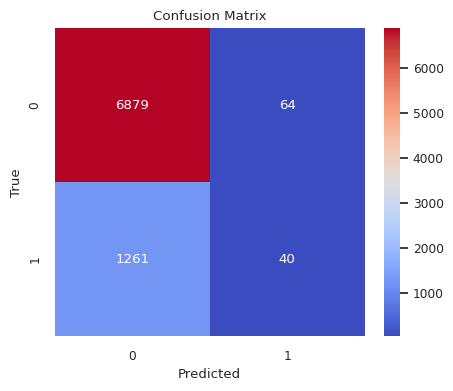

In [ ]:
melhor_modelo = encontra_melhor_modelo(X_train, X_test, y_train, y_test)

## UnderSampling

Remove-se amostras aleatoriamente da classe majoritária (target_default = 0) para que a quantidade seja igual a da classe minoritária (target_default = 1).

In [ ]:
# Class count
df_train = pd.concat([X_train, y_train], axis=1)
count_class_0, count_class_1 = df_train[lbl_y].value_counts()

# Divide by class
df_class_0 = df_train[df_train[lbl_y] == 0]
df_class_1 = df_train[df_train[lbl_y] == 1]

In [ ]:
df_class_0_under = df_class_0.sample(count_class_1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under[lbl_y].value_counts())

Random under-sampling:
0    5287
1    5287
Name: target_default, dtype: int64


In [ ]:
# separar as variáveis independentes da variável alvo
X_train_under = df_train_under.drop(lbl_y, axis=1)
y_train_under = df_train_under[lbl_y]

Performance dos Modelos:
Logistic Regression - Acurácia Balanceada: 0.60470
Random Forest - Acurácia Balanceada: 0.59029
Gradient Boosting - Acurácia Balanceada: 0.61764
XGBoosting - Acurácia Balanceada: 0.59044

Melhor modelo: Gradient Boosting com balanced_accuracy: 0.61764
Acurácia: 0.627.
Acurácia Balanceada: 0.618.
Precisão: 0.235.
Recall: 0.604.
Especificidade: 0.631.
F1: 0.338.

KS: 0.2353 (p-value: 9.319e-54)
ROC AUC: 0.6176




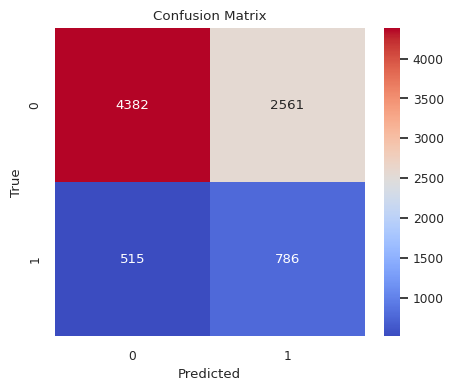

In [ ]:
melhor_modelo = encontra_melhor_modelo(X_train_under, X_test, y_train_under, y_test)

## OverSampling

Duplica-se amostras aleatoriamente da classe minoritária (target_default = 1) para que a quantidade seja igual a da classe majoritária (target_default = 0).

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_train_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random under-sampling:')
print(df_train_over[lbl_y].value_counts())

Random under-sampling:
0    27687
1    27687
Name: target_default, dtype: int64


In [ ]:
# separar as variáveis independentes da variável alvo
X_train_over = df_train_over.drop(lbl_y, axis=1)
y_train_over = df_train_over[lbl_y]

Performance dos Modelos:
Logistic Regression - Acurácia Balanceada: 0.60453
Random Forest - Acurácia Balanceada: 0.52074
Gradient Boosting - Acurácia Balanceada: 0.62616
XGBoosting - Acurácia Balanceada: 0.58464

Melhor modelo: Gradient Boosting com balanced_accuracy: 0.62616
Acurácia: 0.650.
Acurácia Balanceada: 0.626.
Precisão: 0.246.
Recall: 0.591.
Especificidade: 0.661.
F1: 0.348.

KS: 0.2523 (p-value: 7.415e-62)
ROC AUC: 0.6262




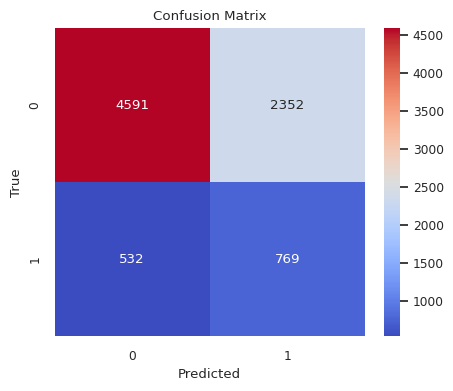

In [ ]:
melhor_modelo = encontra_melhor_modelo(X_train_over, X_test, y_train_over, y_test)

# CONCLUSÃO

Apesar da numerosa quantidade de features disponíveis na base de dados, não foi possível obter mais informações sobre a sistemática de origem destes dados. Portanto para o treinamento do modelo temos um número reduzido de features.

Na análise correlação com a variável target, não foram identificados correlações fortes ou até mesmo medianas, ressaltando a necessidade da inclusão de mais features para treinamento. Considerando estes fatos, não foi realizado o tuning dos hiperparâmetros nem o aprofundamento das features dropadas no início do estudo.

Com relação aos problemas encontrados na amostra (desbalanceamento da variável target) foram testados dois métodos sendo eles: o UnderSampling que busca reduzir a amostra da classe majoritaria e o OverSampling que busca duplicar a amostra da classe minoritária.

Foram obtidos resultados satisfatórios com relação ao modelo inicialmente proposto, tendo o KS e AUC aumentado consideravelmente.

* Desbalanceado<br>
KS: 0.0215 - ROC AUC: 0.5108

* UnderSampling<br>
KS: 0.2486 - ROC AUC: 0.6243

* OverSampling<br>
KS: 0.2447 - ROC AUC: 0.6223


